In [3]:
import numpy as np
import matplotlib.pyplot as plt
import hyperspy.api as hs
import sys
import cv2
from tqdm import tqdm
from scipy import ndimage
import random as rd
from matplotlib.colors import LinearSegmentedColormap
from scipy.ndimage import gaussian_filter
from skimage.exposure import rescale_intensity, adjust_gamma
import pandas as pd
from tqdm import tqdm
import warnings
import pickle
warnings.filterwarnings(action='once')
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
np.set_printoptions(threshold=sys.maxsize)
%matplotlib notebook


def CustomCmap(from_rgb,to_rgb):            ###################### generate colormap

    # from color r,g,b
    r1,g1,b1 = from_rgb

    # to color r,g,b
    r2,g2,b2 = to_rgb

    cdict = {'red': ((0, r1, r1),
                   (1, r2, r2)),
           'green': ((0, g1, g1),
                    (1, g2, g2)),
           'blue': ((0, b1, b1),
                   (1, b2, b2))}

    cmap = LinearSegmentedColormap('custom_cmap', cdict)
    return cmap

cmaps= [                       ###################### generate colormap
    CustomCmap([0,0,0],[1,0,0]),
    CustomCmap([0,0,0],[0,1,0]),
    CustomCmap([0,0,0],[0,0,1]),
    CustomCmap([0,0,0],[1,1,0]),
    CustomCmap([0,0,0],[0,1,1]),
    CustomCmap([0,0,0],[1,0,1]),
    CustomCmap([0,0,0],[.5,0.2,1]),
    CustomCmap([0,0,0],[.2,0.5,1]),
    CustomCmap([0,0,0],[1,.2,.5]),
    CustomCmap([0,0,0],[.2,1,.5])
]
cmaps *= 200

def subtract_background_dog(z, sigma_min, sigma_max):        ###################### background subtract for diffraction image
    blur_max = gaussian_filter(z, sigma_max)
    blur_min = gaussian_filter(z, sigma_min)
    return np.maximum(np.where(blur_min > blur_max, z, 0) - blur_max, 0)
    
import skimage.filters as skifi

#
# Processing a single image
#
def process_image(image, threshold = 1, gamma = 0.2):                # Gamma correction
    # map the minimum to 0
    image = image - image.min()
    # remove the entire diffuse background
    image = subtract_background_dog(image, 0.5, 10)
    # smooth the image
    image = gaussian_filter(image, sigma=1.5)
    # remove low intensity pixels
    image[image < threshold] = 0
    # change the gamma of the images
    image = adjust_gamma(image, gamma)
    # remap intensities to 0-1 range
    image = rescale_intensity(image)
    return image

num_mapping = 3
def plot_non_mix_mapping(loading_matrix, save = False, save_path= f"image/{num_mapping}/merged_mapping.png", annotation=False):
    shape = loading_matrix.shape
    mapping_index = np.zeros([shape[1],shape[2]])
    for i in range(shape[1]):
        for j in range(shape[2]):
            if loading_matrix[:,i,j].max() > 1:
                mapping_index[i, j] = loading_matrix[:,i,j].argmax()
    plt.figure()
    plt.imshow(mapping_index,cmap = 'jet')
    if annotation == True:
        for i in range(loading_matrix.shape[0]):
            plt.annotate(i, ndimage.measurements.center_of_mass(loading_matrix[i])[::-1])
    if save: 
        plt.imsave(save_path, mapping_index, cmap = 'jet')
        
def plot_mix_mapping(loading_matrix, num_plot = 0, gamma = 1, interp_scale = (2,2), plot = False, save = False, save_path= f"image/{num_mapping}/merged_mapping.png", annotation=False):
    shape = loading_matrix.shape
    mapping_index = np.zeros([shape[1],shape[2],4])
    if num_plot == 0: num_plot = shape[0]
    for i in tqdm(range(num_plot)):
        img = adjust_gamma(loading_matrix[i], gamma)
        colored = cmaps[i](img)
        colored[:,:,3] = rescale_intensity(img, out_range=(0,1))
        mapping_index += colored
    mapping_index[:,:,3] = rescale_intensity(mapping_index[:,:,3], out_range=(0,1))
    mapping_index[:,:,0] = rescale_intensity(mapping_index[:,:,0], out_range=(0,1))
    mapping_index[:,:,1] = rescale_intensity(mapping_index[:,:,1], out_range=(0,1))
    mapping_index[:,:,2] = rescale_intensity(mapping_index[:,:,2], out_range=(0,1))
    mapping_index = cv2.resize(mapping_index,None, fx = interp_scale[0], fy = interp_scale[1], interpolation = cv2.INTER_NEAREST)
    if annotation:
        for i in range(num_plot):
            center_of_mass = ndimage.measurements.center_of_mass(loading_matrix[i])[::-1]
            center_of_mass = (int(center_of_mass[0]*interp_scale[0]), int(center_of_mass[1]*interp_scale[1]))
            cv2.putText(mapping_index, str(i), center_of_mass, fontFace = cv2.FONT_ITALIC, fontScale = .4, color = (1.,0.,0.,1.))
    if plot:
        plt.figure()
        plt.imshow(mapping_index,cmap = 'jet')
        if save: 
            plt.imsave(save_path, mapping_index, cmap = 'jet')
    else:
        return mapping_index
    
def save_data(data,loc):
    with open(loc, "wb") as f:
        pickle.dump(data, f)
        
def load_data(loc):
    with open(loc, "rb") as f:
        return pickle.load(f)

<IPython.core.display.Javascript object>


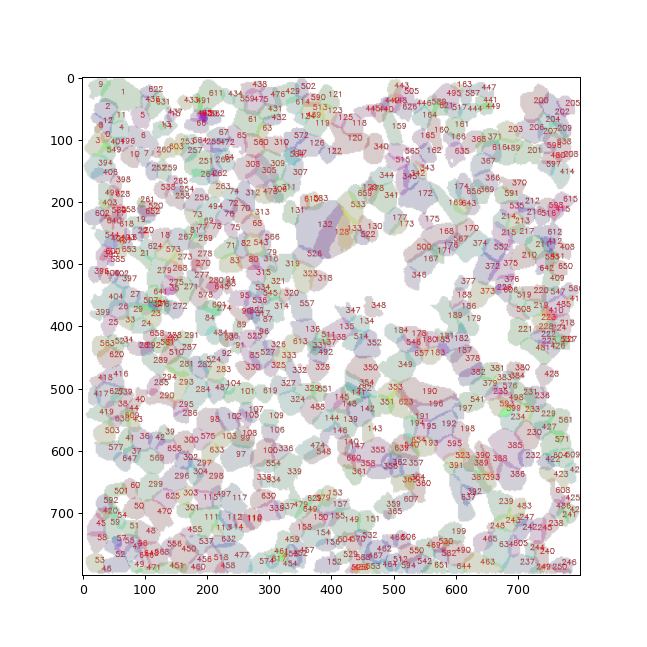

100%|████████████████████████████████████████████████████████████████████████████████████████████| 661/661 [00:05<00:00, 117.26it/s]


True

In [2]:
num_mapping = 9

loadings_all_total = np.load(f"data/loadings_{num_mapping}.npy")
factors_all_total = np.load(f"data/factors_{num_mapping}.npy")

fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(8, 8))
img = plot_mix_mapping(loadings_all_total, num_plot = loadings_all_total.shape[0], annotation = True)
ax.imshow(img)
img = rescale_intensity(img, out_range=(0,255)).astype(int)
# cv2.imwrite('image/grain.png', img)

# align mapping

In [ ]:
############################## align mapping based on pre-calculated perspective_matrixes
def aligned_mapping(load_map, perspective_matrix, output_image_size):
    # perspective matrix is relative to first frame
    # output_image_size is to make sure entire image is in view zone
    load_map_aligned = cv2.warpPerspective(np.float32(load_map), perspective_matrix, output_image_size)
    load_map_aligned = load_map_aligned > 0.5
    return load_map_aligned

perspective_matrixes = np.load('data/perspective_matrixes.npy')
loadings_all_aligned = []
for i in range(loadings_all_total.shape[0]):
    loadings_all_aligned.append(aligned_mapping(loadings_all_total[i], perspective_matrixes[num_mapping-3], (500, 500)))
loadings_all_aligned = np.array(loadings_all_aligned)

# grain register

In [6]:
####################### grain register, orientations by voting all indexes for all pixels in grains based on the sum confidence
from pyxem.utils import indexation_utils as iutls
from scipy.optimize import curve_fit

def vote_orientation(all_index, misori_threshold):
    all_index_sorted = all_index[all_index[:, 3].argsort()[::-1]]
    results = [all_index_sorted[0]]
    for i in range(1, all_index_sorted.shape[0]):
        m = 0
        a = all_index_sorted[i]
        for j in range(len(results)):
            b= results[j]
            if hypot(a[0]-b[0],a[1]-b[1],a[2]-b[2]) < misori_threshold:
                results[j][3] += all_index_sorted[i][3]; m = 1; break;
        if m == 0:
            results.append(all_index_sorted[i])
    results = np.array(results)
    return results

def gauss(x, *p):
    A, sigma = p
    return A*np.exp(-x**2/(2.*sigma**2))

def Guassian_fitting(data):
    if data.shape[0] <= 1: return 0
    p0 = [0.5, 0.5]
    coeff, var_matrix = curve_fit(gauss, data[:,0], data[:,1], p0=p0, bounds = [(0, 0), (1,20)])
    return coeff[1]
    
    
def vote_orientation_w_error(all_index, misori_threshold):
    all_index_sorted = all_index[all_index[:, 3].argsort()[::-1]]
    results = [[all_index_sorted[0]]]
    for i in range(1, all_index_sorted.shape[0]):
        m = 0
        a = all_index_sorted[i]
        for j in range(len(results)):
            b= results[j][0]
            if hypot(a[0]-b[0],a[1]-b[1],a[2]-b[2]) < misori_threshold:
                results[j].append(all_index_sorted[i]); m = 1; break;
        if m == 0:
            results.append([all_index_sorted[i]])
    confid_averaged = []
    misori_confid = []
    angular_error = []
    for i in results:
        if len(i) == 1: misori_confid.append([0,1])
        else:
            for j in i:
                a, b = i[0], j
                misori = hypot(a[0]-b[0],a[1]-b[1],a[2]-b[2])
                misori_confid.append([misori,j[-1]])
#         print(np.array(misori_confid))
        error = Guassian_fitting(np.array(misori_confid))
        angular_error.append(error)
        i[0][-1] = np.array(i)[:,-1].sum()
        confid_averaged.append(i[0])
    merged = np.concatenate([confid_averaged, np.transpose([angular_error])], axis = 1)
    return merged  #[Euler 1, angle 2, angle 3, confid, angle standard deviation]

def ori_std(ori_list): # input angle degree, output angle std Quaternions
    ori_list = np.radians(ori_list)
    ori = Orientation.from_euler(ori_list, symmetry.Oh)
    return ori.data.std(axis = 0)[:3].mean()
    
def build_grain_list(loadings, factors, index_map, perspective_matrixes, output_img_size, original_dataset = 0, index = 'entire_grain'):
    if loadings.shape[0] != factors.shape[0]:
        raise ValueError('different size for loadings and factors')
    grain_list = []
    for num_grain in tqdm(range(loadings.shape[0])):
        grain_1 = grain(loadings[num_grain], factors[num_grain])
        if original_dataset:
            grain_1.update_diff_pattern_center_region(original_dataset, dilation=1)
        if index == 'entire_grain':
            grain_1.indexation(index_map, save_num = 20)
        elif index == 'central_grain':
            grain_1.indexation_center_region(index_map)

        grain_1.aligned_mapping(perspective_matrixes, output_img_size)
        grain_list.append(grain_1)
    return grain_list

class grain:
    def __init__(self, load_map, diff_pattern, contour = False, loc = False, area=False, central_diff_pattern = -1, index = -1):
        if load_map is not None:
            self.load_map = load_map
            self.origin_loc = ndimage.measurements.center_of_mass(load_map)
        if diff_pattern is not None:
            self.diff_pattern = diff_pattern
        if contour:
            self.init_contour = contour
        else:
            if load_map is not None:
                contours, hierarchy = cv2.findContours(np.uint8(binary_erosion(load_map,iterations=1)), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)
                self.init_contour = contours
        if loc:
            self.loc = loc
        else:
            self.loc = self.origin_loc
        
        if area:
            self.area = area
        else:
            self.area = load_map.sum() # nm^2
        self.index = index # keep all 0.9*max_cross_corr, in sequence of cross_corr
        self.central_diff_pattern = central_diff_pattern

        
    def update_diff_pattern_center_region(self, original_dataset, dilation = 2):
        loc = np.array(self.origin_loc).astype(int)
        start_x, start_y = max(0, int(loc[0]-dilation)), max(0, int(loc[1]-dilation))
        end_x, end_y = min(400, int(loc[0]+dilation+1)), min(400, int(loc[1]+dilation+1))
        self.central_diff_pattern = original_dataset.inav[start_y:end_y,start_x:end_x].mean(axis = (0,1))
        self.central_diff_patterns = original_dataset.inav[start_y:end_y,start_x:end_x]
        
    def indexation(self, index_map, filter_misori_threshold = 10, take_num = 1, save_num = 5): 
        # index using pre_indexed mapping - index_map, must be done before any drift correction (for consistency in grain location)
        all_index = index_map[self.load_map][:take_num].reshape(-1, 4)
        all_index_filtered = vote_orientation(all_index, 10)
#         all_index_filtered = vote_orientation_w_error(all_index, 10)
        all_index_filtered = all_index_filtered[all_index_filtered[:, 3].argsort()[::-1]]
        num_to_save = min(save_num, len(all_index_filtered))
        self.index = all_index_filtered[:num_to_save]
        self.index[:,3] = self.index[:,3]/self.index[:,3].sum()  # normalize
        
    def indexation_center_region(self, index_map, filter_misori_threshold = 10, take_num = 1, save_num = 5, dilation = 2): 
        # index using pre_indexed mapping - index_map, must be done before any drift correction (for consistency in grain location)
        loc = np.array(self.origin_loc).astype(int)
        all_index = index_map[loc[0]-dilation:loc[0]+dilation,loc[1]-dilation:loc[1]+dilation][:take_num].reshape(-1, 4)
        all_index_filtered = vote_orientation(all_index, 10)
#         all_index_filtered = vote_orientation_w_error(all_index, 10)
        all_index_filtered = all_index_filtered[all_index_filtered[:, 3].argsort()[::-1]]
        num_to_save = min(save_num, len(all_index_filtered))
        self.index = all_index_filtered[:num_to_save]
        self.index[:,3] = self.index[:,3]/self.index[:,3].sum()  # normalize
        
    def index_by_function(self, lib):    # index self.central_diff_pattern, need update_diff_pattern_center_region first
        
        result, phasedict = iutls.index_dataset_with_template_rotation(self.central_diff_pattern,
                                                    diff_lib_pt, n_best = 10, intensity_transform_function = process_image)
        self.index = np.concatenate([result['orientation'][0][0],np.transpose(result['correlation'][0])],axis=1)
        
    def aligned_mapping(self, perspective_matrix, output_image_size):
        # perspective matrix is relative to first frame
        # output_image_size is to make sure entire image is in view zone
        self.load_map = cv2.warpPerspective(np.float32(self.load_map), perspective_matrix, output_image_size)
        self.load_map = self.load_map > 0.5
        self.loc = ndimage.measurements.center_of_mass(self.load_map)
        self.area = self.load_map.sum() # nm^2
def misori_list_similarity(misori_1, misori_2, threshold_misori):   # return similarity value of two grain orientations
    similarity = 0
    misori_2_list = list(misori_2)
    normalized_factor = np.sum(misori_2[:,3]**2)
    for i in range(len(misori_1)):
        for j in range(len(misori_2_list)):
            if euclidean(misori_1[i][:3], misori_2[j][:3]) < threshold_misori:
#                 print(misori_1[i], misori_2[j])
                similarity += misori_1[i][3] * misori_2[j][3]; del misori_2_list[j]; break;
    return similarity/normalized_factor

def if_grain_aligned(grain_pre, grain_current_map):   #if loc of grain_pre lies in area of grain_current
    loc = np.array(grain_pre.loc).astype(int)
    if grain_current_map[loc[0], loc[1]] == 1:
        return True
    return False

def find_previous_self(grain_list_current, grain_list_previous, threshold_misori_clustering = 15, \
                       loc_search_expand_pixels = 2, misori_similarity_thresh = 0.05, dist_thresh = 2):
    ### build mutual reference for same grain in two frames, based on loc and misorientation
    # find candidates based on location
    grain_pairs = []
    for i,grain_current in enumerate(tqdm(grain_list_current)):
        map_erode = binary_dilation(grain_current.load_map, iterations=loc_search_expand_pixels)
        misori_1 = grain_current.index
        for j,grain_pre in enumerate(grain_list_previous):
            if if_grain_aligned(grain_pre, map_erode):
                misori_2 = grain_pre.index
                similarity = misori_list_similarity(misori_1, misori_2, threshold_misori = threshold_misori_clustering)
                dist = euclidean(grain_current.loc, grain_pre.loc)
                area_diff = abs(grain_current.area - grain_pre.area)/(grain_current.area + grain_pre.area)
                if  similarity > misori_similarity_thresh or dist<dist_thresh:
#                     print(i, j)
                    
                    grain_pairs.append([i,j,dist,similarity,area_diff])  # i is current grain_number, j is previous grain number 
    return grain_pairs


def remove_duplicate_in_grain_pairs(grain_pairs, max_confid_to_keep=0.2, min_dist_to_keep=2, area_diff_percentage_to_keep=0.1, by_loc = False):  # keep only one with nearest dist/highest confid
    # strategy: keep the duplicate element with both highest confid and nearest dist,
                # if not in same element, keep the one with max confid > 0.6
        
    # first do it for grains in first frame
    new_grain_pairs = []
    grain_pairs = np.array(grain_pairs)
    u, c = np.unique(grain_pairs[:,0], return_counts=True)
    dup = u[c > 1]
    mask = np.zeros(grain_pairs.shape[0]).astype(bool)
    dup_filtered = []
    
    if len(dup) > 0:
        for dup_elements in dup:
            mask = np.bitwise_or(mask, grain_pairs[:,0] == dup_elements)
            dup_element = grain_pairs[grain_pairs[:,0] == dup_elements]
            max_confid = dup_element[:,3].argmax()
            min_dist = dup_element[:,2].argmin()
            if by_loc:
                dup_filtered.append(dup_element[min_dist])
            else:
                if max_confid == min_dist:          # if one in all candidates shows both smallest dist and highest similarity, keep it
                    dup_filtered.append(dup_element[max_confid])
                elif dup_element[min_dist, 3] < min_dist_to_keep and dup_element[min_dist, 4] < area_diff_percentage_to_keep: # if dist is small, grain size is close, keep it
                    dup_filtered.append(dup_element[min_dist])
                elif dup_element[max_confid, 3] > max_confid_to_keep:  # else if the max confidence > max_confid_to_keep, also keep it
                    dup_filtered.append(dup_element[max_confid])

    mask = (1-mask).astype(bool)
    new_grain_pairs = grain_pairs[mask]
    if len(dup_filtered) > 0:
        new_grain_pairs = np.concatenate([new_grain_pairs, np.array(dup_filtered)])

    # then do it for grains in second frame
    new_grain_pairs_2 = []
    new_grain_pairs = np.array(new_grain_pairs)
    u, c = np.unique(new_grain_pairs[:,1], return_counts=True)
    dup = u[c > 1]
    mask = np.zeros(new_grain_pairs.shape[0]).astype(bool)
    dup_filtered = []
    if len(dup)>0:
        for dup_elements in dup:
            mask = np.bitwise_or(mask, new_grain_pairs[:,1] == dup_elements)
            dup_element = new_grain_pairs[new_grain_pairs[:,1] == dup_elements]
            max_confid = dup_element[:,3].argmax()
            min_dist = dup_element[:,2].argmin()
            if by_loc:
                dup_filtered.append(dup_element[min_dist])
            else:
                if max_confid == min_dist:          # if one in all candidates shows both smallest dist and highest similarity, keep it
                    dup_filtered.append(dup_element[max_confid])
                elif dup_element[min_dist, 3] < min_dist_to_keep and dup_element[min_dist, 4] < area_diff_percentage_to_keep: # if dist is small, grain size is close, keep it
                    dup_filtered.append(dup_element[min_dist])
                elif dup_element[max_confid, 3] > max_confid_to_keep:  # else if the max confidence > max_confid_to_keep, also keep it
                    dup_filtered.append(dup_element[max_confid])

    mask = (1-mask).astype(bool)
    new_grain_pairs_2 = new_grain_pairs[mask]
    if len(dup_filtered) > 0:
        new_grain_pairs_2 = np.concatenate([new_grain_pairs_2, np.array(dup_filtered)])
    
    new_grain_pairs_2 = new_grain_pairs_2[new_grain_pairs_2[:, 0].argsort()]
    return new_grain_pairs_2

# start processing data for two dataset

100%|███████████████████████████████████████████████████████████████████████████████| 885/885 [00:12<00:00, 68.65it/s]


<IPython.core.display.Javascript object>


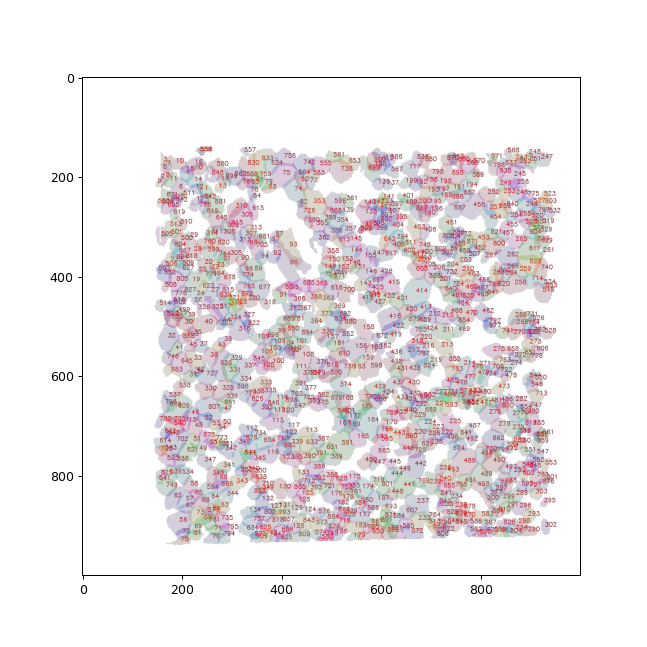

100%|███████████████████████████████████████████████████████████████████████████████| 997/997 [00:14<00:00, 67.06it/s]


<IPython.core.display.Javascript object>


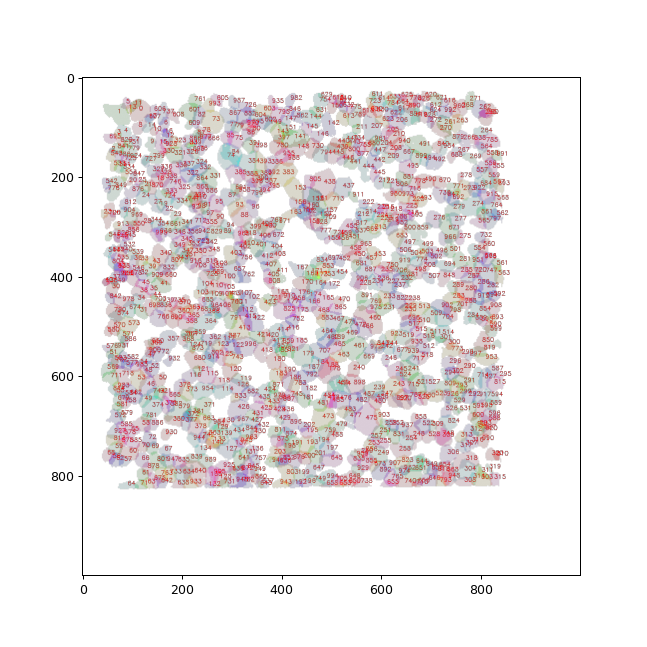

100%|███████████████████████████████████████████████████████████████████████████████| 997/997 [00:11<00:00, 89.67it/s]


In [14]:
num_mapping = 6    #current frame

index_map = np.load(f'data/index_mapping_10_condidates_{num_mapping}.npy')
data_file = hs.load(("data/"+str(num_mapping)+".hspy"),lazy=True)
loadings_all_total = np.load(f"data/loadings_{num_mapping}.npy")
factors_all_total = np.load(f"data/factors_{num_mapping}.npy")
grain_list = build_grain_list(loadings_all_total, factors_all_total, index_map, 
                              perspective_matrixes[num_mapping-3], (500, 500), data_file)

loadings_all_aligned = []
for i in range(loadings_all_total.shape[0]):
    loadings_all_aligned.append(grain_list[i].load_map)
loadings_all_aligned = np.array(loadings_all_aligned)
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(8, 8))
img = plot_mix_mapping(loadings_all_aligned, num_plot = loadings_all_aligned.shape[0], annotation = True)
ax.imshow(img)


num_mapping = 5     #previous frame

index_map = np.load(f'data/index_mapping_10_condidates_{num_mapping}.npy')
data_file = hs.load(("data/"+str(num_mapping)+".hspy"),lazy=True)
loadings_all_total = np.load(f"data/loadings_{num_mapping}.npy")
factors_all_total = np.load(f"data/factors_{num_mapping}.npy")
grain_list_2 = build_grain_list(loadings_all_total, factors_all_total, index_map, perspective_matrixes[num_mapping-3], (500, 500), data_file)

loadings_all_aligned = []
for i in range(loadings_all_total.shape[0]):
    loadings_all_aligned.append(grain_list_2[i].load_map)
loadings_all_aligned = np.array(loadings_all_aligned)
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(8, 8))
img = plot_mix_mapping(loadings_all_aligned, num_plot = loadings_all_aligned.shape[0], annotation = True)
ax.imshow(img)

In [13]:
grain_pairs = find_previous_self(grain_list, grain_list_2)
grain_pairs = np.array(grain_pairs)
grain_pairs_filtered = remove_duplicate_in_grain_pairs(grain_pairs)
print(grain_pairs_filtered.shape)
print(grain_pairs_filtered)

100%|███████████████████████████████████████████████████████████████████████████████| 885/885 [00:04<00:00, 219.92it/s]

(431, 5)
[[0.00000000e+00 3.32000000e+02 5.27411083e-01 1.23226410e+00
  4.04312668e-02]
 [1.00000000e+00 6.86000000e+02 3.07018824e+00 3.11144306e-01
  2.06008584e-01]
 [2.00000000e+00 3.28000000e+02 3.95061149e+00 4.97494793e-01
  6.70588235e-01]
 [4.00000000e+00 3.22000000e+02 1.31226196e+00 4.32066788e-01
  8.17438692e-03]
 [5.00000000e+00 3.36000000e+02 2.34052109e+00 5.40109154e-01
  4.62686567e-01]
 [6.00000000e+00 3.25000000e+02 4.50192917e-01 5.67527900e-01
  6.94444444e-03]
 [8.00000000e+00 3.38000000e+02 1.61175686e+00 1.10779581e+00
  9.20245399e-02]
 [1.00000000e+01 3.35000000e+02 4.25976582e+00 1.05184696e+00
  1.26843658e-01]
 [1.20000000e+01 8.68000000e+02 5.67176186e-01 3.77340495e-01
  3.20000000e-02]
 [1.60000000e+01 3.24000000e+02 1.10236735e+00 6.76563663e-01
  1.29973475e-01]
 [2.00000000e+01 8.16000000e+02 1.45115611e+00 1.52548753e-01
  8.95883777e-02]
 [2.20000000e+01 3.52000000e+02 8.56028117e-01 9.29596607e-01
  1.63934426e-02]
 [2.30000000e+01 1.08000000e+02

313 399 1.1399228116505087 0.0 0.1963470319634703


<IPython.core.display.Javascript object>


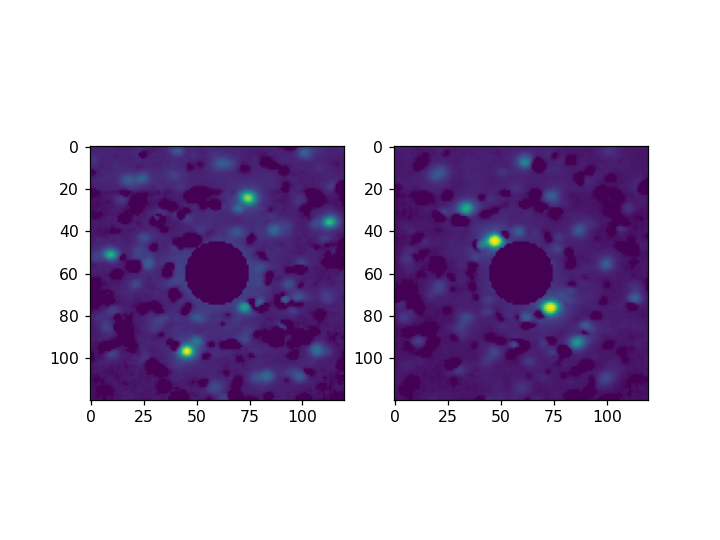

In [14]:
# check data for i in current and j in previous
i, j, loc, confid, area_diff = rd.choice(grain_pairs_filtered[:])
i, j, loc, confid, area_diff = rd.choice(grain_pairs_filtered[grain_pairs_filtered[:,3]<0.5])   # look for pairs with low similarity
print(int(i), int(j), loc, confid, area_diff)
plt.figure()
plt.subplot(1,2,1)
plt.imshow(adjust_gamma(grain_list[int(i)].diff_pattern, 0.4))
plt.subplot(1,2,2)
plt.imshow(adjust_gamma(grain_list_2[int(j)].diff_pattern, 0.4))
# print(grain_list[52].index,grain_list_2[60].index)

# process all datasets and conbine grain_pairs into grain_chains

In [ ]:
grain_list_all = []
for num_mapping in range(3, 10):
    index_map = np.load(f'data/index_mapping_10_condidates_{num_mapping}.npy')
    data_file = hs.load(("data/"+str(num_mapping)+".hspy"),lazy=True)
    loadings_all_total = np.load(f"data/loadings_{num_mapping}.npy")
    factors_all_total = np.load(f"data/factors_{num_mapping}.npy")
    grain_list = build_grain_list(loadings_all_total, factors_all_total, index_map, 
                                  perspective_matrixes[num_mapping-3], (500, 500), data_file,index = 'central_grain')
    grain_list_all.append(grain_list)
    pickle.dump(grain_list, 'data/grain_list.dat')
    
    loadings_all_aligned = []
    for i in range(loadings_all_total.shape[0]):
        loadings_all_aligned.append(grain_list[i].load_map)
    loadings_all_aligned = np.array(loadings_all_aligned)
#     fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(8, 8))
#     img = plot_mix_mapping(loadings_all_aligned, num_plot = loadings_all_aligned.shape[0], annotation = True)
#     ax.imshow(img)
#     img = rescale_intensity(img, out_range=(0,255)).astype(int)
#     cv2.imwrite(f'image/grain_marked{num_mapping}.png', img)



In [751]:
# save all grain pairs in dict
all_grain_pairs = dict([])
for num_mapping_1 in tqdm(np.arange(9, 3, -1)):
    for num_mapping_2 in np.arange(num_mapping_1-1, 2, -1):
        grain_list_1, grain_list_2 = grain_list_all[num_mapping_1-3], grain_list_all[num_mapping_2-3]
        grain_pairs = find_previous_self(grain_list_1, grain_list_2)
        grain_pairs = np.array(grain_pairs)
        grain_pairs_filtered = remove_duplicate_in_grain_pairs(grain_pairs,by_loc=True)
        grain_pairs_filtered = np.array(grain_pairs_filtered)
        all_grain_pairs[str(num_mapping_1)+str(num_mapping_2)] = grain_pairs_filtered

100%|███████████████████████████████████████████████████████████████████████████████| 661/661 [00:03<00:00, 184.76it/s]

100%|███████████████████████████████████████████████████████████████████████████████| 661/661 [00:03<00:00, 179.20it/s]

100%|███████████████████████████████████████████████████████████████████████████████| 661/661 [00:03<00:00, 178.02it/s]

 63%|█████████████████████████████████████████████████▋                             | 416/661 [00:02<00:01, 171.28it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 661/661 [00:03<00:00, 169.05it/s]

100%|███████████████████████████████████████████████████████████████████████████████| 661/661 [00:04<00:00, 152.04it/s]

 38%|██████████████████████████████                                                 | 276/724 [00:01<00:02, 177.30it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 724/724 [00:04<00:00, 177.90it/s]

100%|███████████████████████████████████████████████████████████████████████████████| 724/724 [00:04<00:00, 177.91it/s]

100%|███████████████████████████████████████████████████████████████████████████████| 724/724 [00:04<00:00, 166.74it/s]

 54%|██████████████████████████████████████████▉                                    | 394/724 [00:02<00:02, 151.06it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 724/724 [00:04<00:00, 149.09it/s]

100%|███████████████████████████████████████████████████████████████████████████████| 816/816 [00:04<00:00, 169.80it/s]



100%|███████████████████████████████████████████████████████████████████████████████| 816/816 [00:05<00:00, 150.15it/s]

100%|███████████████████████████████████████████████████████████████████████████████| 816/816 [00:05<00:00, 149.98it/s]

 39%|███████████████████████████████                                                | 321/816 [00:03<00:04, 103.75it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 885/885 [00:05<00:00, 165.61it/s]

 66%|███████████████████████████████████████████████████▊                           | 580/885 [00:03<00:02, 150.68it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 885/885 [00:05<00:00, 151.74it/s]

 53%|██████████████████████████████████████████▏                                    | 533/997 [00:03<00:03, 134.58it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 997/997 [00:07<00:00, 140.40it/s]

 13%|██████████▏                                                                   | 153/1173 [00:01<00:09, 106.28it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:59<00:00, 19.99s/it]


In [23]:
# save all grain pairs
import pickle
f=open(f'data/grain_list_by_loc.pickle','rb')
all_grain_pairs = pickle.load(f)
f.close()

In [24]:
# merge adjecent grain chains into long chains
grain_chain_1 = all_grain_pairs['98'][:,:2].astype(int)
grain_chain_2 = all_grain_pairs['87'][:,:2].astype(int)
grain_chain_new = []

grain_chain_1 = np.concatenate([  grain_chain_1, [[-1] for i in range(grain_chain_1.shape[0])]  ],axis = 1)
grain_chain_2 = np.concatenate([  [[-1] for i in range(grain_chain_2.shape[0])], grain_chain_2  ],axis = 1)
grain_chain_new = np.concatenate([grain_chain_1,grain_chain_2])
to_combine_list = []
conbined_chain = []
for i in range(grain_chain_new.shape[0]-1):
    for j in range(i+1, grain_chain_new.shape[0]):
        if grain_chain_new[i,1] == grain_chain_new[j,1]:
            to_combine_list.append([i,j])
            combined = np.concatenate([grain_chain_new[i,:2], [grain_chain_new[j,2]]])
            conbined_chain.append(combined)
to_combine_list = np.array(to_combine_list).flatten()            
mask = np.ones(grain_chain_new.shape[0]).astype(bool)
mask[to_combine_list] = False
grain_chain_new = grain_chain_new[mask]
grain_chain_new = np.concatenate([grain_chain_new, conbined_chain])
grain_chain_new = grain_chain_new[grain_chain_new[:,0].argsort()]

for num_mapping in np.arange(7, 3, -1):
    print(num_mapping)
    grain_chain_1 = grain_chain_new
    num_pairs = str(num_mapping)+str(num_mapping-1)
    grain_chain_2 = all_grain_pairs[num_pairs][:,:2].astype(int)
    grain_chain_new = []

    grain_chain_1 = np.concatenate([  grain_chain_1, [[-1] for i in range(grain_chain_1.shape[0])]  ],axis = 1)
    joint_point = 9-num_mapping
    grain_chain_2 = np.concatenate([  [[-1]*joint_point for i in range(grain_chain_2.shape[0])], grain_chain_2  ],axis = 1)
    grain_chain_new = np.concatenate([grain_chain_1,grain_chain_2])
    to_combine_list = []
    conbined_chain = []
    for i in range(grain_chain_new.shape[0]-1):
        if grain_chain_new[i,joint_point] == -1: continue;
        for j in range(i+1, grain_chain_new.shape[0]):
            if grain_chain_new[i,joint_point] == grain_chain_new[j,joint_point]:
                to_combine_list.append([i,j])
                combined = np.concatenate([grain_chain_new[i,:-1], [grain_chain_new[j,-1]]])
                conbined_chain.append(combined)
    to_combine_list = np.array(to_combine_list).flatten()            
    mask = np.ones(grain_chain_new.shape[0]).astype(bool)
    mask[to_combine_list] = False
    grain_chain_new = grain_chain_new[mask]
    grain_chain_new = np.concatenate([grain_chain_new, conbined_chain])
    grain_chain_new = grain_chain_new[grain_chain_new[:,0].argsort()]
    
    
    
    

7
6
5
4


In [ ]:
def save_data(data,loc):
    with open(loc, "wb") as f:
        pickle.dump(data, f)
        
def load_data(loc):
    with open(loc, "rb") as f:
        return pickle.load(f)

save_data(grain_chain_new, "D:/data/grain_chain.dat")